In [ ]:
from sms_norm import normalize_and_hash_series, dedupe_by_hash
from sms_embed import embed_dedup_dataframe, save_embeddings
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan
from plots import *
from sklearn.preprocessing import normalize


Embedding dimension: 384


In [38]:
# Load the ready-made synthetic data
df_raw = pd.read_csv("./artifacts/synthetic_one_originator.csv")  # <-- move the downloaded file there OR change path

# Normalize + dedupe
norm = normalize_and_hash_series(df_raw["raw_text"], seed=0)
norm.insert(0, "originator_id", df_raw["originator_id"])
norm.insert(1, "message_id", df_raw["message_id"])
dedup_df, _ = dedupe_by_hash(norm)

# Embed (offline MiniLM) and save CSV+NPY
LOCAL_MODEL = r"C:/models/all-MiniLM-L6-v2"  # local model folder
meta_df, X = embed_dedup_dataframe(
    dedup_df, text_col="normalized_text", id_col="template_hash_xx64",
    batch_size=64, normalize=True, model_name=LOCAL_MODEL
)
csv_path, npy_path = save_embeddings(meta_df, X, out_dir="./artifacts", prefix="week_synth")
print("Saved:", csv_path, npy_path)

Saved: ./artifacts\week_synth.csv ./artifacts\week_synth.npy


C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\eliei\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster counts: {np.int64(-1): np.int64(3), np.int64(0): np.int64(5), np.int64(1): np.int64(6), np.int64(2): np.int64(6), np.int64(3): np.int64(6), np.int64(4): np.int64(11)}


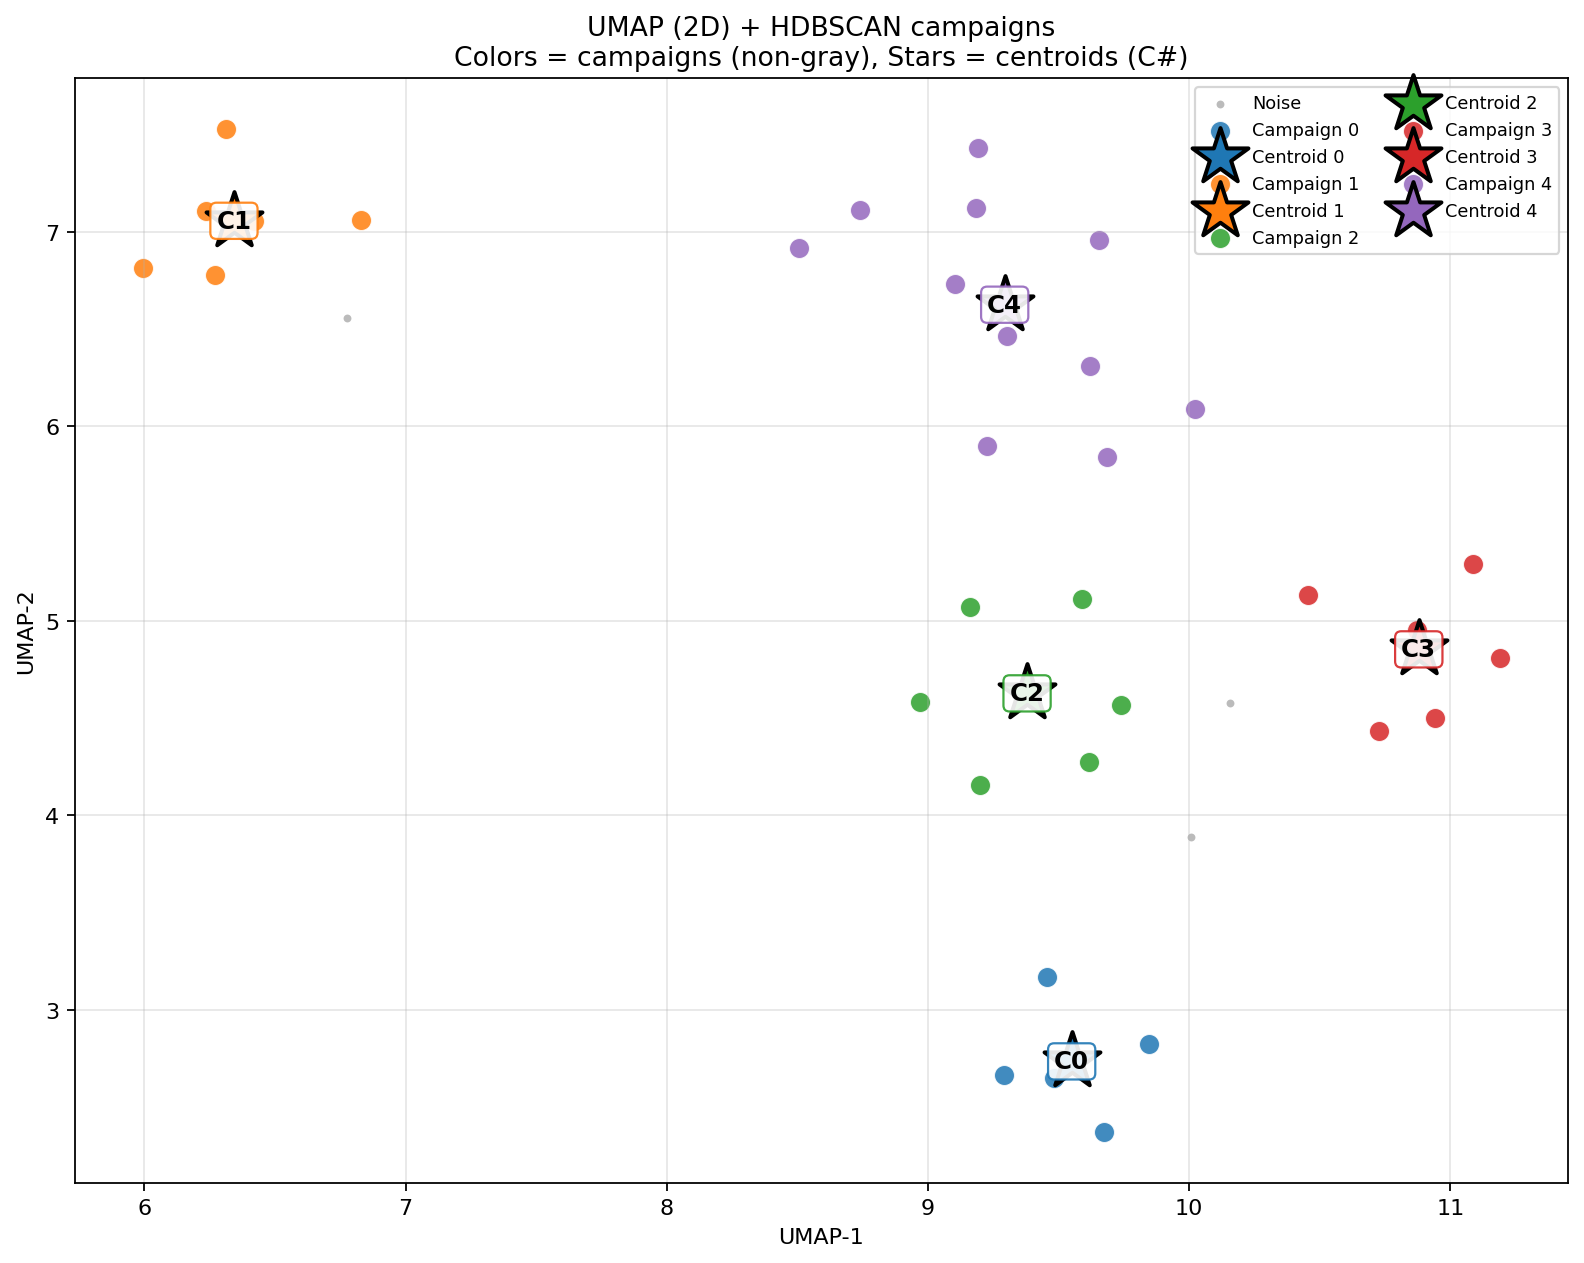

Saved:
 - campaigns.csv : ./artifacts\campaigns.csv
 - campaigns.npy : ./artifacts\campaigns.npy
 - points.csv    : ./artifacts\points.csv
 - plot          : ./artifacts\umap_hdbscan_campaigns.png


In [39]:
# UMAP + HDBSCAN + centroids + exemplars + plot (one originator)

import os
import numpy as np
import pandas as pd
import umap
import hdbscan
from plots import plot_campaigns

ART_DIR   = "./artifacts"
PREFIX    = "week_synth"  # from Stage 4 save_embeddings(...)
META_CSV  = os.path.join(ART_DIR, f"{PREFIX}.csv")
VEC_NPY   = os.path.join(ART_DIR, f"{PREFIX}.npy")

assert os.path.exists(META_CSV) and os.path.exists(VEC_NPY), "Run Stage 4 first to create CSV+NPY."

# Load meta + embeddings
meta = pd.read_csv(META_CSV)
X    = np.load(VEC_NPY)  # shape [N, D]

# Safety: ensure unit-norm (cosine-ready)
X = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), 1e-12)

# UMAP to 2D (for visualization only)

#umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    force_approximation_algorithm=False,  # ensures deterministic neighbor graph
    transform_seed=42,                    # fixes transform randomness
)

X_2d = umap_model.fit_transform(X)  # [N, 2]

import joblib
joblib.dump(umap_model, "./artifacts/umap_model.pkl")

# HDBSCAN (auto number of clusters); -1 = noise
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,   # smaller -> more clusters; increase if too many
    min_samples=2,        # lower -> less noise
    metric="euclidean"    # OK because X is unit-norm; euclidean ~ cosine
)
labels = clusterer.fit_predict(X)
print("Cluster counts:", dict(zip(*np.unique(labels, return_counts=True))))

# Compute centroids in ORIGINAL 384-D space + exemplars per cluster
def compute_centroids_and_exemplars(X, labels, k=3):
    cluster_ids = sorted([c for c in set(labels) if c != -1])
    C = []
    rows = []
    for row_idx, c in enumerate(cluster_ids):              # // NEW: keep row_idx
        idx = np.where(labels == c)[0]
        # centroid in original embedding space (384-D), unit-norm
        cvec = X[idx].mean(axis=0)
        cvec = cvec / (np.linalg.norm(cvec) + 1e-8)
        C.append(cvec)

        # exemplars: closest to centroid by cosine (dot with unit vectors)
        sims = X[idx] @ cvec
        ord_idx = idx[np.argsort(-sims)]
        ex_texts = [meta.iloc[i]["normalized_text"] for i in ord_idx[:k]]

        rows.append({
            "row_index": row_idx,         # // NEW: row index in campaigns.npy
            "cluster_label": int(c),      # // NEW: explicit mapping row->label
            "size": int(len(idx)),
            "exemplar_1": ex_texts[0] if len(ex_texts) > 0 else "",
            "exemplar_2": ex_texts[1] if len(ex_texts) > 1 else "",
            "exemplar_3": ex_texts[2] if len(ex_texts) > 2 else "",
        })
    C = np.vstack(C) if len(C) else np.zeros((0, X.shape[1]), dtype=np.float32)
    return cluster_ids, C, pd.DataFrame(rows)

cluster_ids, C, campaigns_df = compute_centroids_and_exemplars(X, labels, k=3)

# Save artifacts
os.makedirs(ART_DIR, exist_ok=True)
campaigns_csv = os.path.join(ART_DIR, "campaigns.csv")
campaigns_npy = os.path.join(ART_DIR, "campaigns.npy")
points_csv    = os.path.join(ART_DIR, "points.csv")
plot_path     = os.path.join(ART_DIR, "umap_hdbscan_campaigns.png")

campaigns_df.to_csv(campaigns_csv, index=False, encoding="utf-8")
np.save(campaigns_npy, C.astype(np.float32))

# Keep the per-point label column name consistent as 'label'
pd.DataFrame({
    "template_hash_xx64": meta["template_hash_xx64"],
    "normalized_text": meta["normalized_text"],
    "umap_x": X_2d[:, 0], # type: ignore
    "umap_y": X_2d[:, 1], # type: ignore
    "label": labels                      # <-- we'll read 'label' later
}).to_csv(points_csv, index=False, encoding="utf-8")

plot_campaigns(X_2d, labels, cluster_ids, plot_path)

print("Saved:")
print(" - campaigns.csv :", campaigns_csv)
print(" - campaigns.npy :", campaigns_npy)
print(" - points.csv    :", points_csv)
print(" - plot          :", plot_path)


In [43]:
# === Stage 6: Distance-based drift (0–1), similar to your first cell (no saving) ===
# Outputs:
#   A_tuple (GLOBAL): (mean_distance, std_distance, noise_rate, global_drift, alpha, tau_d)
#   B_tuple (PER-CAMPAIGN): ([(campaign_row, campaign_label, mean_distance_c, std_distance_c, n_c), ...], macro_mean_distance)

import numpy as np
import pandas as pd

from sms_norm import normalize_and_hash_series, dedupe_by_hash
from sms_embed import embed_dedup_dataframe

# --- Paths ---
REF_CENTROIDS_PATH = "./artifacts/campaigns.npy"      # 384-D centroids (K, D)
REF_CENTROIDS_MAP  = "./artifacts/campaigns.csv"      # row_index -> cluster_label
#NEW_MESSAGES_CSV_PATH = "./artifacts/syntheric_one_originator_new_data.csv"  # raw_text only
NEW_MESSAGES_CSV_PATH = "./artifacts/mixed_160_orig__40_new.csv"  # raw_text only
#NEW_MESSAGES_CSV_PATH = "./artifacts/synthetic_one_originator.csv"  # raw_text only


# --- Embedding model ---
LOCAL_MODEL = r"C:/models/all-MiniLM-L6-v2"   # offline MiniLM

# --- Drift params ---
tau_d = 0.20   # distance threshold for "noise" (1 - cosine > tau_d)
alpha = 0.70   # blend for GlobalDrift

# --- helper ---
def _row_l2_normalize(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    nrm = np.maximum(nrm, eps)
    return X / nrm

# 1) Load new data (raw_text)
df_raw = pd.read_csv(NEW_MESSAGES_CSV_PATH)

# 2) Normalize + dedupe
norm = normalize_and_hash_series(df_raw["raw_text"].astype(str), seed=0)
dedup_df, _ = dedupe_by_hash(norm)

# 3) Embed (unit-norm)
meta_df, X = embed_dedup_dataframe(
    dedup_df, text_col="normalized_text", id_col="template_hash_xx64",
    batch_size=64, normalize=True, model_name=LOCAL_MODEL
)

# 4) Load 384-D centroids (+ mapping row_index → cluster_label)
C = np.load(REF_CENTROIDS_PATH)
C = _row_l2_normalize(C)

try:
    cmap_df = pd.read_csv(REF_CENTROIDS_MAP).sort_values("row_index")
    centroid_labels = cmap_df["cluster_label"].to_numpy(dtype=int)   # ← array, not dict
except Exception:
    centroid_labels = np.arange(C.shape[0], dtype=int)               # fallback: 0..K-1

# 5) Distances to nearest centroid (0–1) and assignments
cos = X @ C.T
s_max = cos.max(axis=1)
a_idx = cos.argmax(axis=1)            # nearest centroid *row* in campaigns.npy
d = 1.0 - s_max
noise_mask = d > tau_d

# -------------------------
# A) GLOBAL METRICS & RANK
# -------------------------
mean_d = float(d.mean()) if len(d) else float("nan")
std_d  = float(d.std(ddof=0)) if len(d) else float("nan")
noise_rate = float(noise_mask.mean()) if len(d) else float("nan")
global_drift = alpha * mean_d + (1.0 - alpha) * noise_rate

# >>> A_tuple (GLOBAL) <<<
# (mean_distance, std_distance, noise_rate, global_drift, alpha, tau_d)
A_tuple = (mean_d, std_d, noise_rate, global_drift, alpha, tau_d)

# -----------------------------------
# B) PER-CAMPAIGN METRICS (covered)
# -----------------------------------
covered = ~noise_mask
covered_idx = np.where(covered)[0]
per_campaign = []  # (campaign_row, campaign_label, mean_distance_c, std_distance_c, n_c)

if covered_idx.size > 0:
    a_cov = a_idx[covered_idx]
    d_cov = d[covered_idx]
    for c_row in np.unique(a_cov):
        mask_c = (a_cov == c_row)           # shape == len(covered_idx)
        d_c = d_cov[mask_c]                 # <-- FIX: index the covered distances, not full d
        mu_c = float(d_c.mean())
        sd_c = float(d_c.std(ddof=0))
        n_c  = int(mask_c.sum())
        c_lab = int(centroid_labels[c_row]) if centroid_labels is not None else int(c_row)
        per_campaign.append((int(c_row), c_lab, mu_c, sd_c, n_c))
    macro_mean = float(np.mean([m[2] for m in per_campaign])) if per_campaign else float("nan")
else:
    macro_mean = float("nan")

# >>> B_tuple (PER-CAMPAIGN) <<<
# ( [ (campaign_row, campaign_label, mean_distance_c, std_distance_c, n_c), ... ], macro_mean_distance )
B_tuple = (per_campaign, macro_mean)

# --- Optional prints ---
print("A_tuple (GLOBAL):", A_tuple)
print("B_tuple sample (first 5):", per_campaign[:5], "macro_mean_distance:", macro_mean)


A_tuple (GLOBAL): (0.3942696452140808, 0.2516036927700043, 0.5882352941176471, 0.4524593398851507, 0.7, 0.2)
B_tuple sample (first 5): [(0, 0, 0.17731104791164398, 0.015458750538527966, 3), (1, 1, 0.11587829887866974, 0.02580842562019825, 5), (2, 2, 0.16775667667388916, 0.0019995809998363256, 6), (4, 4, 0.13961844146251678, 0.05243673175573349, 7)] macro_mean_distance: 0.15014111623167992


# debug plot of new data

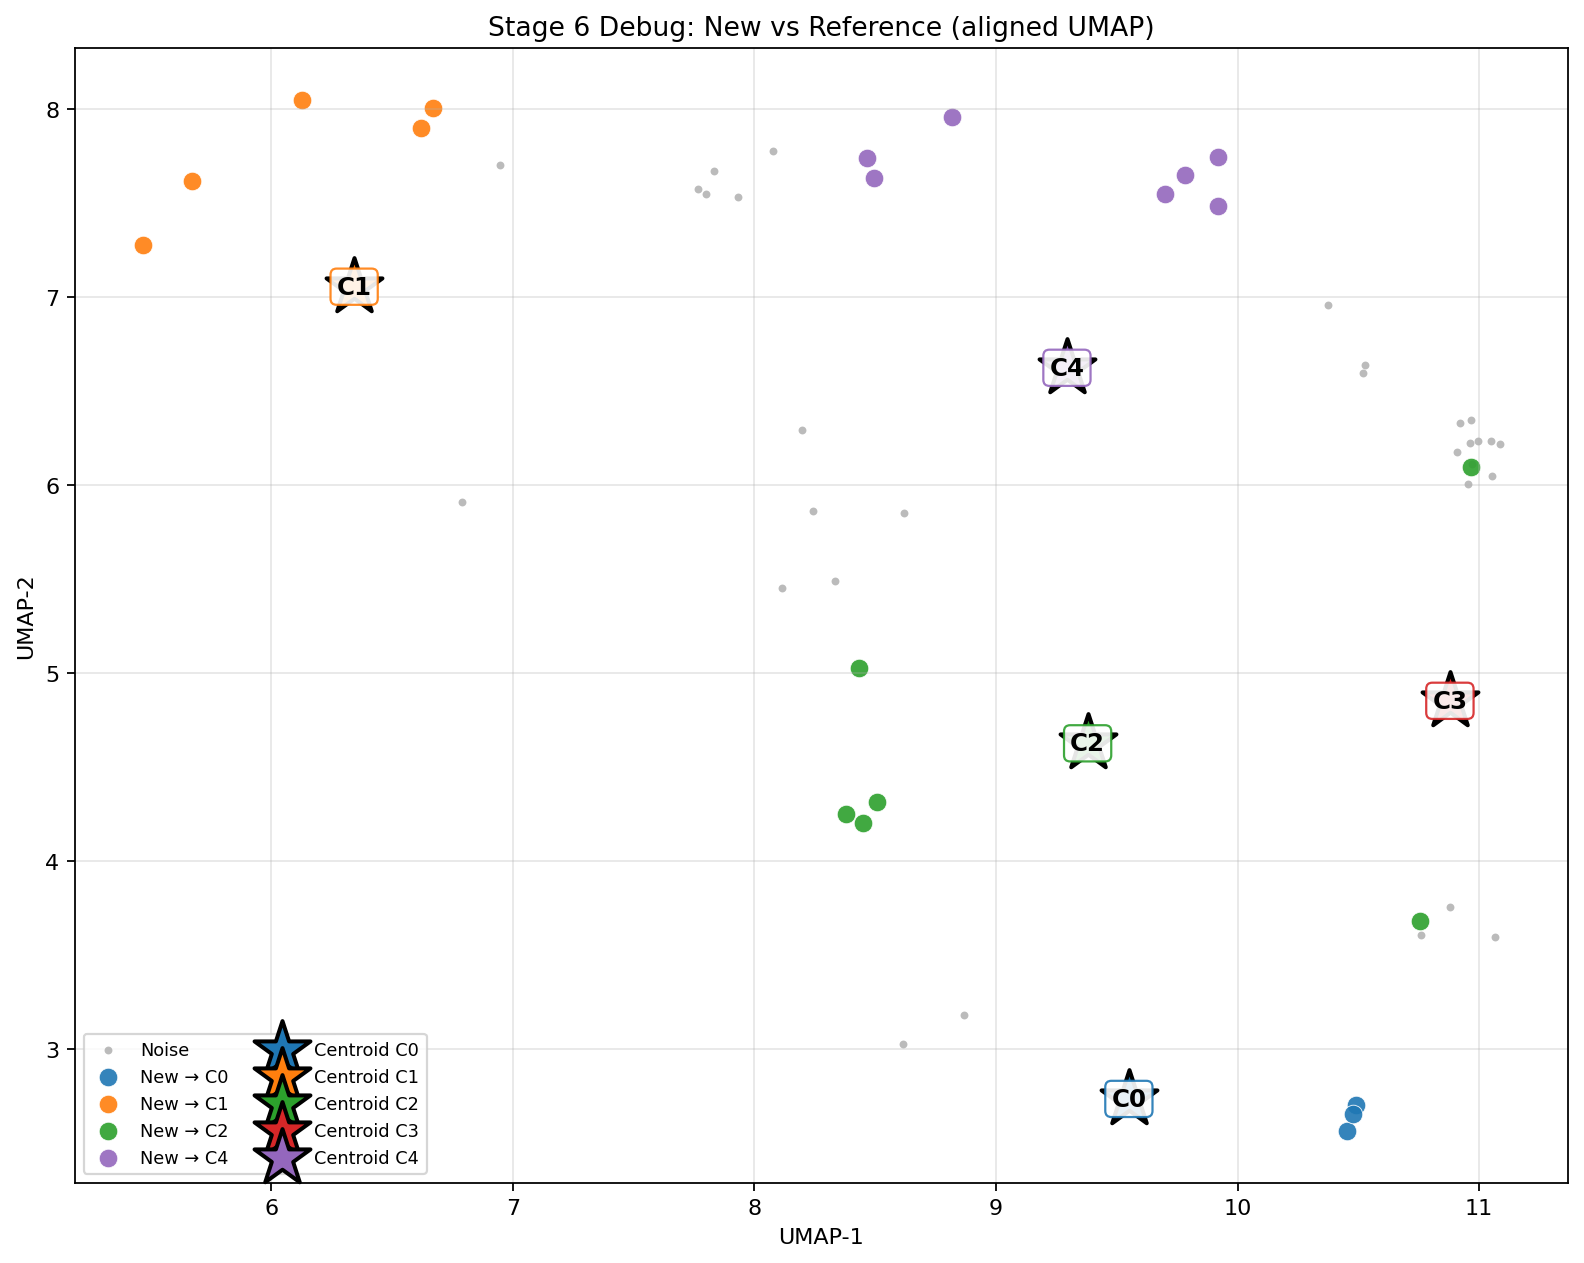

In [44]:
# === Stage 6: Debug plot (aligned with Stage 5 UMAP) ===
# - Uses saved Stage-5 reducer (umap_model.pkl) with deterministic transform
# - Stars = mean of saved Stage-5 2D coords (points.csv)
# - New points: colored by assigned centroid's LABEL; noise in gray

import joblib
import importlib
import numpy as np
import pandas as pd

# load artifacts
umap_model = joblib.load("./artifacts/umap_model.pkl")          # same reducer from Stage 5
points_df  = pd.read_csv("./artifacts/points.csv")              # has 'umap_x','umap_y','label'
X_ref      = np.load("./artifacts/week_synth.npy")              # optional (not used if X_ref_2d passed)
X_ref_2d   = points_df[["umap_x","umap_y"]].to_numpy()
ref_labels = points_df["label"].to_numpy()

# row -> label mapping (used to color new points by campaign label)
cmap_df = pd.read_csv("./artifacts/campaigns.csv").sort_values("row_index")
centroid_labels = cmap_df["cluster_label"].to_numpy(dtype=int)

# plotting function (reloaded to ensure latest version with X_ref_2d=)
import plots
importlib.reload(plots)
from plots import plot_ref_stars_mean2d_with_new

# call the plotter (reuses a_idx, noise_mask, C, X from Cell 1)
plot_ref_stars_mean2d_with_new(
    reducer=umap_model,
    X_ref=X_ref,                 # not used if X_ref_2d provided; kept for API symmetry
    ref_labels=ref_labels,
    C=C,
    X_new=X,
    a_idx=a_idx,
    noise_mask=noise_mask,
    centroid_labels=centroid_labels,
    X_ref_2d=X_ref_2d,           # ensures stars match Stage-5 exactly
    title="Stage 6 Debug: New vs Reference (aligned UMAP)",
    save_path="./artifacts/stage6_debug_umap.png",
)


In [32]:
# reload plots if has changed
import importlib
import plots
importlib.reload(plots)

from plots import plot_ref_stars_mean2d_with_new